# Final Bureaucratic Levels Under Discounting

In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize
import pandas as pd
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
from matplotlib.lines import Line2D
from scipy.special import lambertw
import warnings
import pickle
import ipynb.fs.defs.Functions_Equilibria_Along_Parameters as sliceFuncs
import ipynb.fs.defs.Functions_Equations_Equilibrium_Simulation as baseFuncs
import ipynb.fs.defs.Functions_Optimizer as optFuncs

In [4]:
def finalBureaucratics(tau, T, t_max, vals, run_to_eql = False, start_from_equil = False, 
                       load_prev = False, print_periodicity = False, nameAddit = ""):    
    # Equilibrium bureaucratic metric vals
    para = baseFuncs.paraReset()
    con = lambda x: x[0]+x[1]
    cons = {'type':'ineq', 'fun': con}
    res = minimize(baseFuncs.equilGeneralAnalytic, [0.01, 0.01], args = (para, -1), bounds = ((0, 1), (0, 1)), constraints = cons)
    rules = baseFuncs.equilGeneralAnalytic(res.x, para, return_rules = True)
    eql_prop_w_A = para['k_A']*(rules[0]+rules[1])/para['w_max']
    eql_prop_Ro = rules[1]/(rules[0]+rules[1])
       
    # Simulate
    bureau_fin = []
    periodic = []
    for it, val in enumerate(vals): #enumerate(np.linspace(0,0.1,mesh)):
        para = baseFuncs.paraReset()
        para['dt'] = 0.25 # To make the simulation more efficient.
        para['r_d'] = 0.1
        para['discount_rate'] = val
        
        saveName = f"dynOpt{nameAddit}, T = {T}, tau = {tau}, discount rate = {para['discount_rate']}, to equil = {run_to_eql}"
        saveName_fig=f"dynOpt{nameAddit}, T={T}, tau = {tau}, discount rate = {para['discount_rate']}, to equil = {run_to_eql}.png"
        if load_prev:
            loadName = f"Discounted Optimizations/dynOpt{nameAddit}, T = {T}, tau = {tau}, discount rate = {para['discount_rate']}, to equil = {run_to_eql}"
            file = open(loadName, 'rb')
            data = pickle.load(file)
            file.close()
        else:
            data = optFuncs.optimizer(para, tau, T, t_max, loadPrevious = 0, saveData = 1, 
                                      loadName = "", saveName = saveName, saveLog = 0, run_to_eql = run_to_eql, tol = 1)
        f, Pxx_den = sp.signal.periodogram(data["opt_d"][0::int(data['tau']/para['dt'])+2])

        # Here, we consider the average beaucratic metrics if we are within the oscillatory region.
        if max(Pxx_den) > 0.5:
            periodic.append(True)
            # First, we try to take the average over the period
            try:
                signal_peaks, _ = sp.signal.find_peaks(data["w_D_vals"][0::int(data['tau']/para['dt'])+2])
                tau_sig_Ro = data["prop_Ro"][0::int(data['tau']/para['dt'])+2]
                tau_sig_wA = data["prop_wA"][0::int(data['tau']/para['dt'])+2]
                final_prop_Ro = np.average(tau_sig_Ro[signal_peaks[-2]:signal_peaks[-1]])
                final_prop_wA = np.average(tau_sig_wA[signal_peaks[-2]:signal_peaks[-1]])
                if print_periodicity:
                    print("Periodic:", final_prop_Ro, final_prop_wA)
            # But we may not have generated long enough to get a full period
            except Exception as exceptMsg:
                if not load_prev: # So, if we are simulating already, we simulate again with double the timespan
                    exception_bfin, _ = finalBureaucratics(tau, T, 2*t_max, [val], run_to_eql, load_prev, showFig, 
                                                           saveFig, print_periodicity, nameAddit = "Doubled")
                    final_prop_Ro = exception_bfin[0][0]
                    final_prop_wA = exception_bfin[0][1]
                else: # If we are only reading data, then we take the average since the peak.
                    signal_peaks, _ = sp.signal.find_peaks(data["w_D_vals"][0::int(data['tau']/para['dt'])+2])
                    tau_sig_Ro = data["prop_Ro"][0::int(data['tau']/para['dt'])+2]
                    tau_sig_wA = data["prop_wA"][0::int(data['tau']/para['dt'])+2]
                    final_prop_Ro = np.average(tau_sig_Ro[signal_peaks[-1]:])
                    final_prop_wA = np.average(tau_sig_wA[signal_peaks[-1]:])
        # Or, if our result was not periodic, then we take the final position values.   
        else:
            periodic.append(False)
            final_prop_Ro = data["prop_Ro"][-1]
            final_prop_wA = data["prop_wA"][-1]
            if print_periodicity:
                print("Non-periodic:", final_prop_Ro, final_prop_wA)
        
        bureau_fin.append((final_prop_Ro, final_prop_wA))
        
    return bureau_fin, periodic

In [2]:
def plotSavedFinalBureau(fig, ax, tau, T, vals = np.linspace(0,0.1,21), showTitle = True, showLegend = True, run_to_eql = False,
                         titleText = "Bureaucratic Metrics for Varying \n Discount Rates Initialized from ($R_u$, $R_o$) = (1,0)", 
                         boldTitle = False, fontsize = 14):
    bureau_fin, periodic = finalBureaucratics(tau = tau, T = T, t_max = 500, vals = vals, run_to_eql = run_to_eql,
                                              load_prev = True, print_periodicity = False, nameAddit = "")
    prop_Ros, prop_wAs = zip(*bureau_fin)
    ax.plot(vals, prop_Ros, label = "Obsolete Process Proportion", color = "orange", linestyle = "--", linewidth = 2)
    ax.plot(vals, prop_wAs, label = "Admin. Cost", color = "blue", linewidth = 2)
    ax.plot(vals, np.asarray(prop_wAs)*np.asarray(prop_Ros), label = "Admin. Waste", color = "red", linestyle = ":", linewidth = 2)
    ax.set_ylim([0,1])
    ax.set_xlim([np.min(vals), np.max(vals)])

    # Label business
    ticks_temp = np.round(np.linspace(np.min(vals), np.max(vals), 5), 2)
    ticks_vals = [t_val for t_it, t_val in enumerate(ticks_temp) if t_it != 2]
    ax.set_xlabel(r'Discount Rate', fontsize = fontsize, va = 'top')
    t = offset_copy(ax.transAxes, y=-(ax.xaxis.labelpad + ax.xaxis.majorTicks[0].get_pad()), fig=fig, units='points')
    ax.xaxis.set_label_coords(0.5, 0, transform=t)
    ax.set_xticks(ticks_vals)
    
    if showTitle:
        if boldTitle:
            plt.title(titleText, fontsize = fontsize, fontweight = "bold")
        else:
            plt.title(titleText, fontsize = fontsize)
    if showLegend:
        ax.legend(loc = "lower right")
    ax.set_ylabel("Admin. Measures", fontsize = fontsize)

## To Generate the data: uncomment and execute the function below (takes over an hour)

In [ ]:
#bureau_fin, periodic = finalBureaucratics(3, 120, 6000, np.linspace(0,0.1,11), run_to_eql = True, start_from_equil = False, load_prev = False, print_periodicity = True, nameAddit = "")

#### Plotting saved data

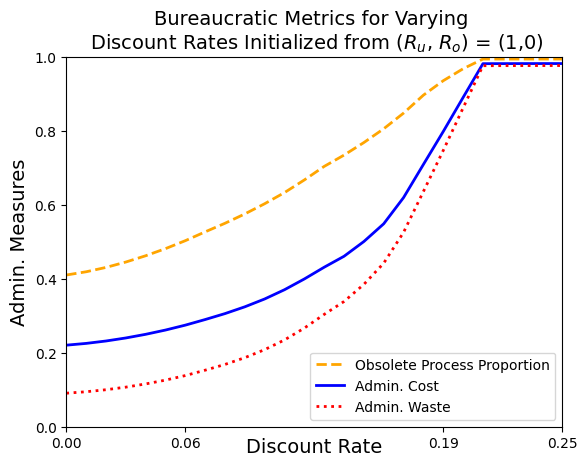

In [5]:
fig, ax = plt.subplots(1,1)
plotSavedFinalBureau(fig, ax, 3, 120, np.linspace(0.0,0.25,26), showTitle = True, showLegend = True, run_to_eql = True)
plt.show()